In [1]:
import glob
from pickle import load
trainings = list()
filelist = list(glob.glob('results*.pickle'))
for file in filelist:
    trainings.append(load(open(file, 'rb')))

trainings = trainings[0]

In [2]:
pretrainings = sorted({x['pretrained'] for x in trainings[0]})
configs, results_ = trainings

2 1 0.5855787289142608 0.6190860748291016


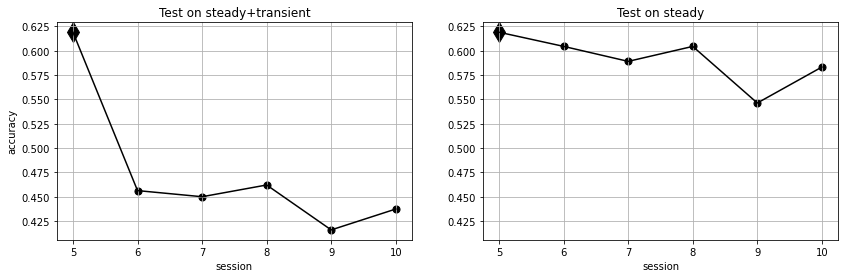

2 2 0.6095614677667618 0.6520839869976044


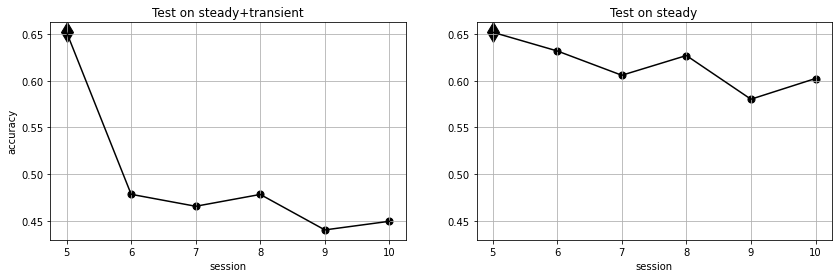

2 4 0.607993637919426 0.6707383751869201


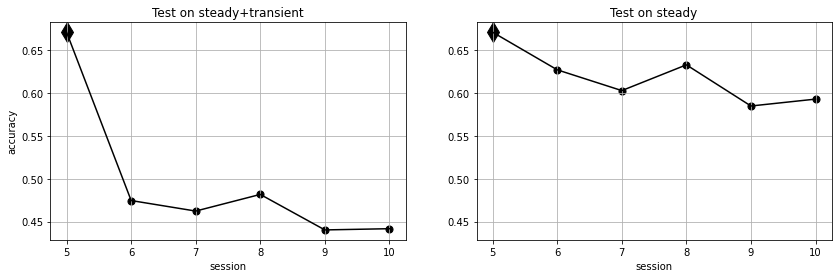

2 8 0.6033281069993974 0.6660152554512024


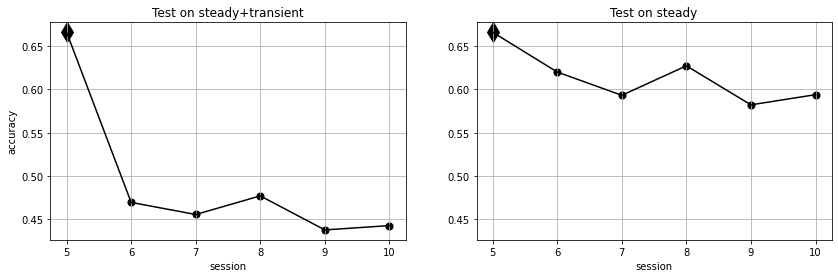

4 1 0.6121553099155426 0.651435774564743


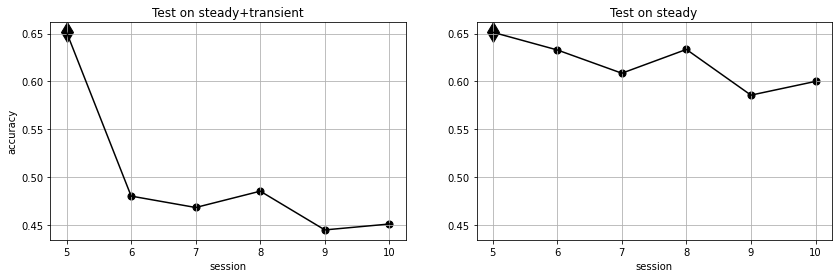

4 2 0.623070981502533 0.6735384523868561


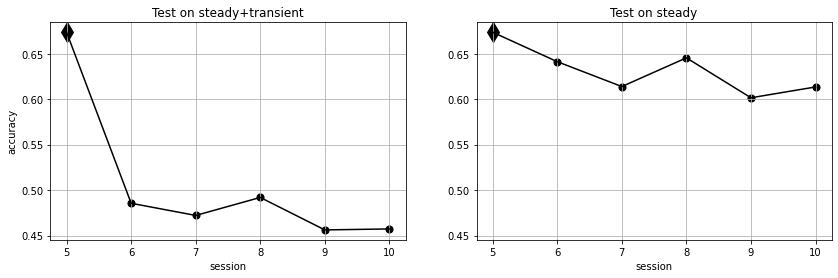

4 4 0.615461083650589 0.6848322510719299


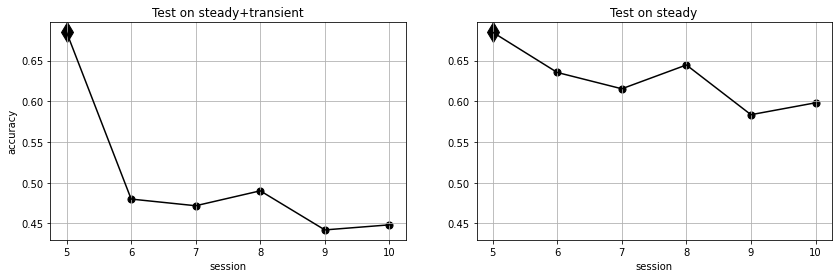

4 8 0.6163954031467437 0.6907239973545074


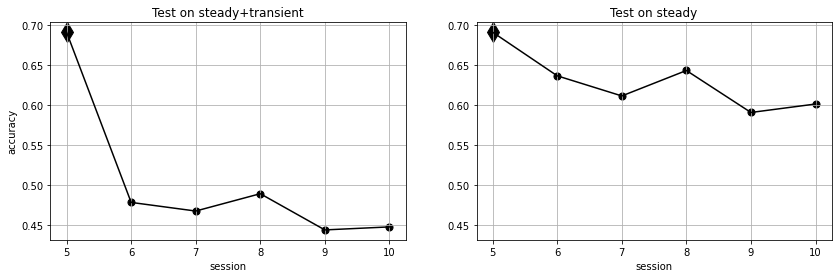

8 1 0.630914494395256 0.6698649108409882


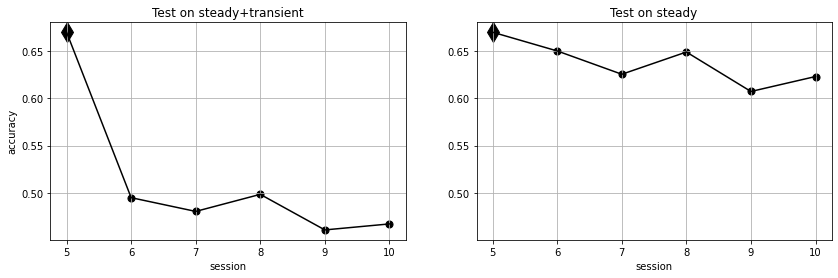

8 2 0.626677286028862 0.692080307006836


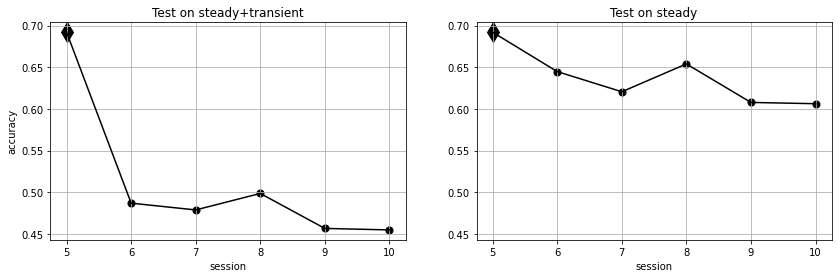

8 4 0.6164402151107788 0.6975175738334656


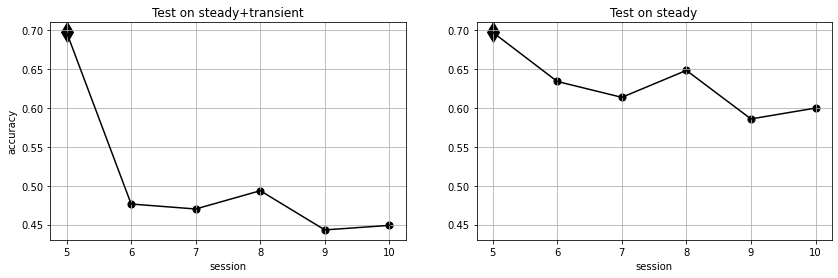

8 8 0.6225971323251723 0.6976920783519744


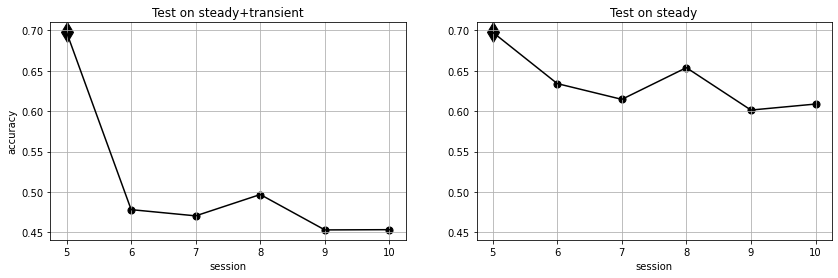

In [3]:
# Problemi:
# - preso modello ultima epoca e non il migliore
# - val acc calcolata sempre su steady e non anche su non steady
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

heads = [2, 4, 8]
depth = [1, 2, 4, 8,]

scores_val = np.zeros((3, 4))
scores_test = np.zeros((3, 4))

for pretraining in pretrainings:
    
    acccs = []
    acccs_steady = []
    
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler("color", ["#000000", '#000000'])
    fix, (ax1, ax2) = plt.subplots(figsize=(14, 4), ncols=2)
    ax1.grid(True)
    ax2.grid(True)
    ax1.set_title("Test on steady+transient")
    ax2.set_title("Test on steady")
    
    chosen_config = None
    
    for n_idx, (config, r) in enumerate(zip(configs, results_)):
                
        if config["pretrained"] != pretraining:
            continue
                        
        chosen_config = config

        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs_steady /= 2

        #acc_val = .5 * r['val-fold_0']['losses_accs'][-1]['val_acc'] + .5 * r['val-fold_1']['losses_accs'][-1]['val_acc']
        acc_val =  r['val-fold_0']['losses_accs'][-1]['val_acc']

        y = [acc_val] + [a for a in accs]
        acccs.append(y)

        y = [acc_val] + [a for a in accs_steady]
        acccs_steady.append(y)
                

    acccs = np.array(acccs).mean(axis=0)
    acccs_steady = np.array(acccs_steady).mean(axis=0)

    x = [r['test_sessions'][0]] + [a for a in np.array(r['test_sessions']) + 1]
    y1 = [a for a in acccs]
    y2 = [a for a in acccs_steady]
    m = ['d'] + (['o'] * (len(x) - 1))
    s = [200] + [50] * (len(x) - 1)

    ax1.plot(x, y1, color=f'C{n_idx}')
    for xp, yp, m_, s_ in zip(x, y1, m, s):
        ax1.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C{n_idx}')

    ax2.plot(x, y2, color=f'C{n_idx}')
    for xp, yp, m_, s_ in zip(x, y2, m, s):
        ax2.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C{n_idx}')
        
        
    (min1, max1), (min2, max2) = ax1.get_ylim(), ax2.get_ylim()
    min_ = min(min1, min2)
    max_ = max(max1, max2)
    ax1.set_ylim((min_, max_))
    ax2.set_ylim((min_, max_))

    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax1.set_xlabel("session")
    ax2.set_xlabel("session")
    ax1.set_ylabel("accuracy")

    print(chosen_config['heads'], chosen_config['depth'], np.array(acccs_steady)[1:].mean(), acccs_steady[0])
    
    scores_val[heads.index(chosen_config["heads"]), depth.index(chosen_config["depth"])] = acccs_steady[0]
    scores_test[heads.index(chosen_config["heads"]), depth.index(chosen_config["depth"])] = np.array(acccs_steady)[1:].mean()
    
    plt.show()

[[0.58557873 0.60956147 0.60799364 0.60332811]
 [0.61215531 0.62307098 0.61546108 0.6163954 ]
 [0.63091449 0.62667729 0.61644022 0.62259713]]


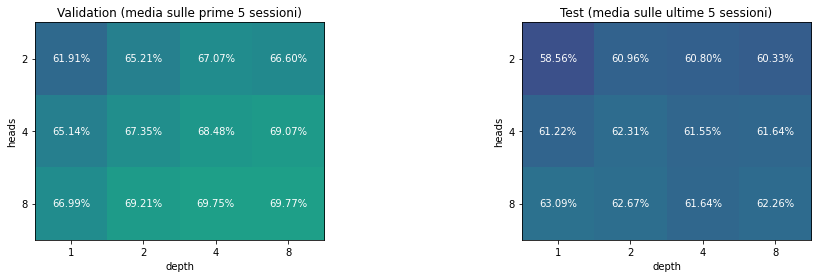

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, axes = plt.subplots(figsize=(8*2, 4), ncols=2)
print(scores_test)
for idx, scores in enumerate([scores_val, scores_test]):
    ax = axes[idx]
    m = ax.imshow(scores, interpolation='nearest',  vmin=.5, vmax=.85)#cmap=plt.cm.hot)
    ax.set_ylabel('heads')
    ax.set_xlabel('depth')

    ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(len(heads))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(heads))
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(len(depth))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(depth))

    #ax.set_title(f'{"Training" if idx % 2 == 0 else "Test"}\ndim_head={dim_head},dim={64 if idx < 2 else 14*20}\nhidden=2*dim')
    ax.set_title('Validation (media sulle prime 5 sessioni)' if idx == 0 else 'Test (media sulle ultime 5 sessioni)')
    for i in range(len(heads)):
        for j in range(len(depth)):
            text = ax.text(j, i, f"{scores[i, j]*100:.2f}%",
                           ha="center", va="center", color="w")

heads2_depth1_epoch100.pth


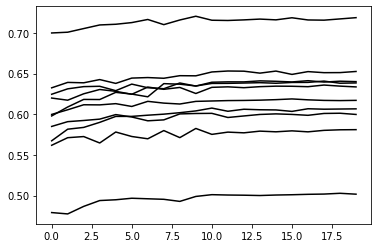

heads2_depth2_epoch100.pth


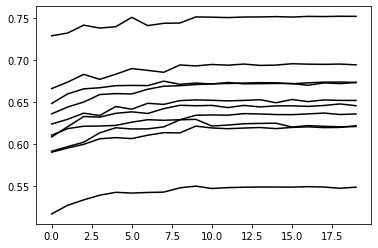

heads2_depth4_epoch100.pth


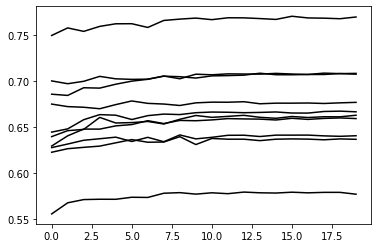

heads2_depth8_epoch100.pth


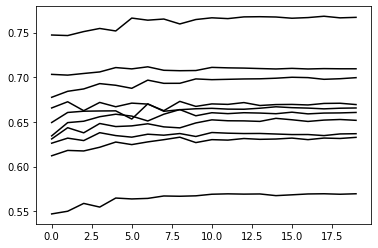

heads4_depth1_epoch100.pth


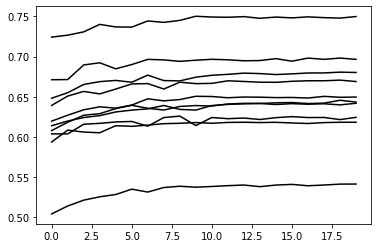

heads4_depth2_epoch100.pth


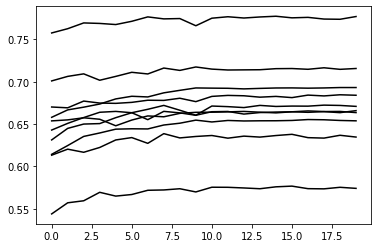

heads4_depth4_epoch100.pth


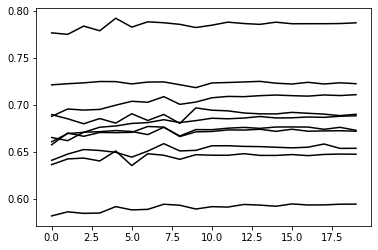

heads4_depth8_epoch100.pth


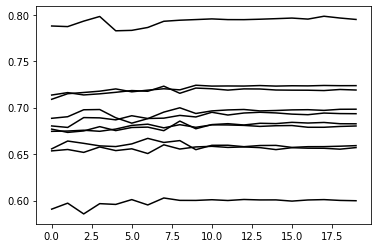

heads8_depth1_epoch100.pth


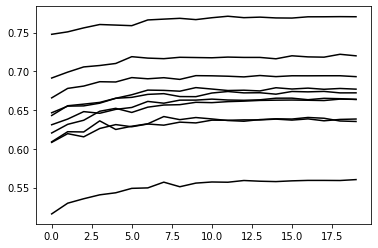

heads8_depth2_epoch100.pth


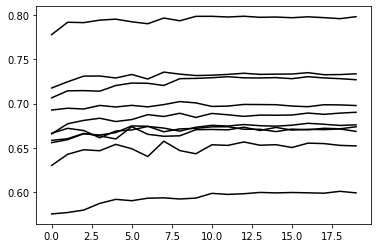

heads8_depth4_epoch100.pth


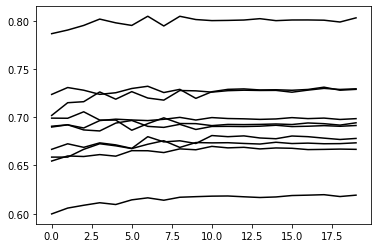

heads8_depth8_epoch100.pth


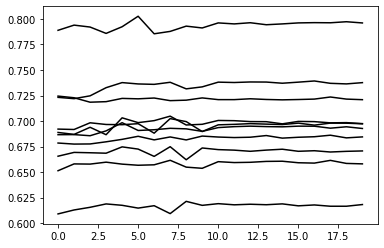

In [5]:
for pretraining in pretrainings:
    print(pretraining)
    for n_idx, (config, r) in enumerate(zip(configs, results_)):
        if config["pretrained"] != pretraining:
            continue
        plt.plot([r['val-fold_0']['losses_accs'][i]['val_acc'] for i in range(20)])    
    plt.show()